In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rc("figure", **{"figsize": (16,10)})
np.random.seed(27182)

from ou_market_making import OrnsteinUhlenbeck, PriceProcess, MeanRevertingStrategy, round_to

# Intuition

#### Ornstein–Uhlenbeck Process

$$\begin{aligned}
    \text{The }&\text{continuous case:} \\
    dX_t &= \theta(\mu-X_t)dt + \sigma dB_t \\
    X_{t_{i+1}} &= X_{t_i} + \int_{t_i}^{t_{i+1}} \theta(\mu-X_s)ds + \int_{t_i}^{t_{i+1}} \sigma dB_s \\
    \text{The }&\text{discrete case:} \\
    \Delta X_{t_i} &= \theta(\mu-X_{t_i})\Delta t + \sigma \Delta B_{t_i} \\
    X_{t_{i+1}} &= X_{t_i} + \Delta X_{t_i}
\end{aligned}$$

$\mu$ is the "mean" of the process, AKA the long-run expectation.

$\theta$ is the mean reversion strength. What happens when $\theta \to 0$? $\theta \to \infty$?

What is $Var[B_t]$ as $t \to \infty$? $Var[X_t]$ as $t \to \infty$?

In [2]:
# GLOBALS

N_STEPS = int(1e3)
X0 = 10
X0 = 0

TICKSIZE = 0.1

# Set up parameters from above
theta  = 7
mu     = X0
sigma  = 3
deltat = 1e-2

ou = OrnsteinUhlenbeck(X0, theta, mu, sigma, deltat)
pripro = PriceProcess(ou, TICKSIZE)

pripro.generate(N_STEPS)

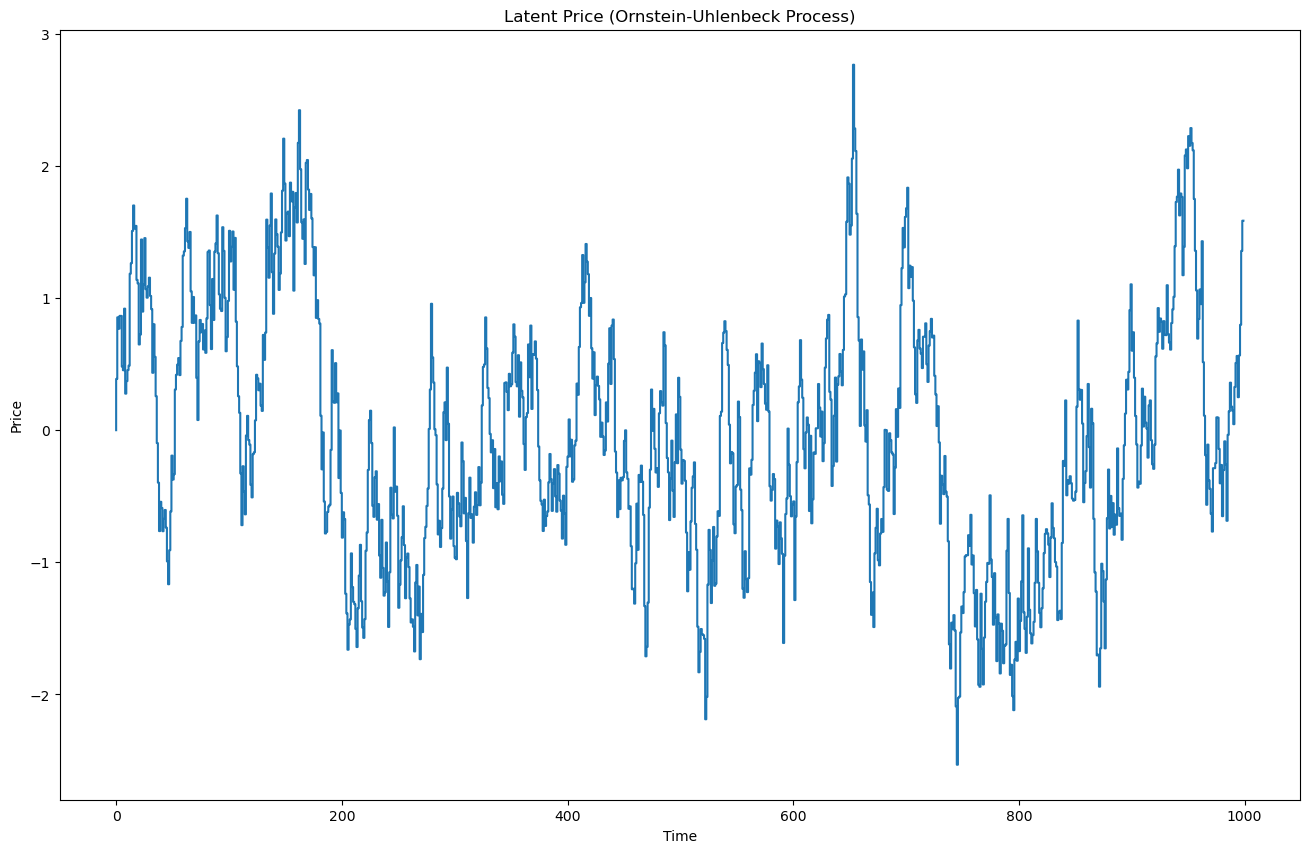

In [14]:
N_FIRST = 50

slice = pripro.time < N_FIRST
temp_latent_price = pripro.latent_price[slice]
lo, hi = temp_latent_price.min(), temp_latent_price.max()

fig, axis = plt.subplots()

pripro.plot_latent_price(axis)
# axis.add_patch(Rectangle((0, lo), N_FIRST, hi-lo, edgecolor='r', fill=False))

plt.show()

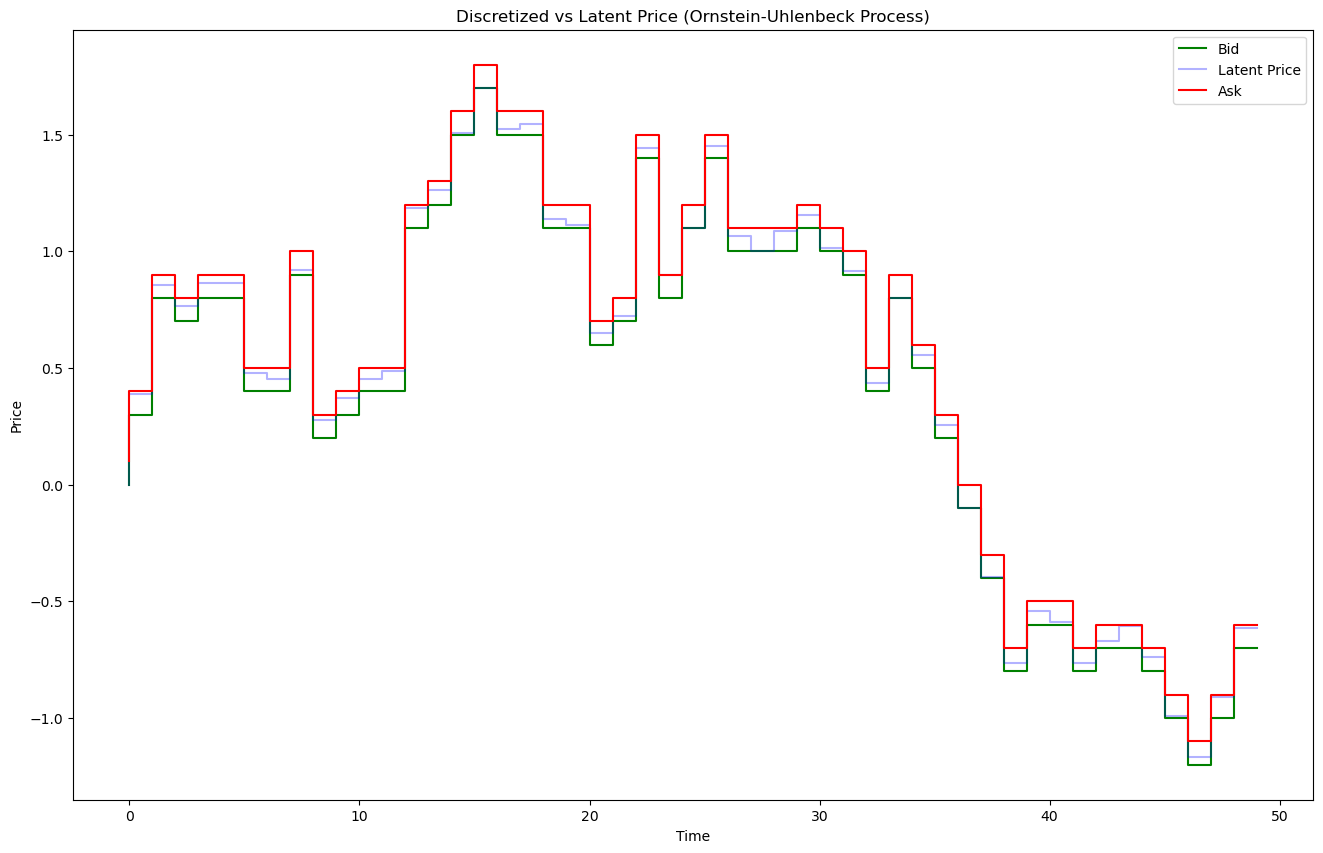

In [4]:
fig, axis = plt.subplots()

pripro.plot_bid_ask(axis, slice)

plt.show()

# Intuition

Given the difference equation, we can estimate where 

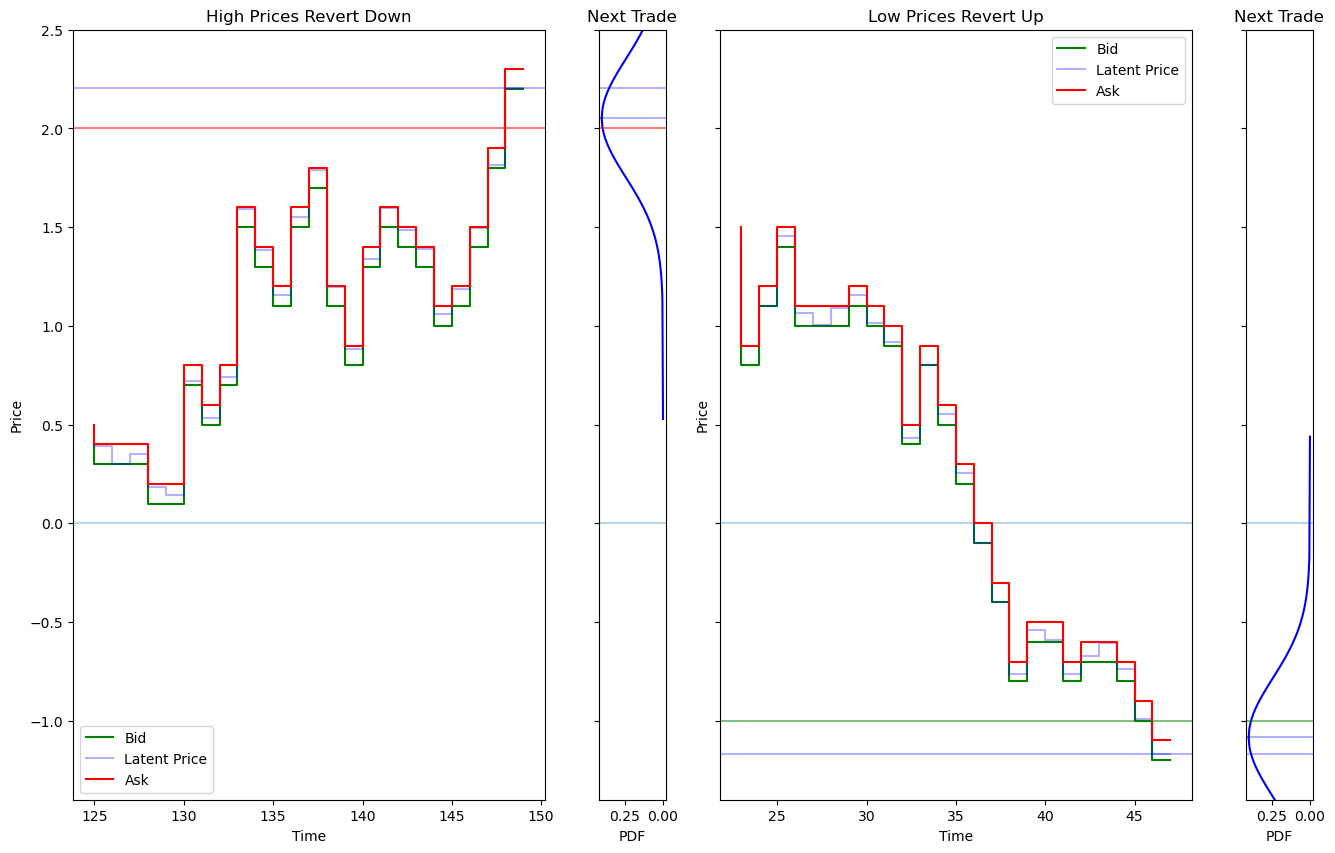

In [5]:
slice = N_FIRST / 2

hi_bound = X0 + 20*TICKSIZE
lo_bound = X0 - 10*TICKSIZE

hi_loc = np.argmax(pripro.latent_price>hi_bound)
lo_loc = np.argmax(pripro.latent_price<lo_bound)
hi_latent = pripro.latent_price[hi_loc]
lo_latent = pripro.latent_price[lo_loc]

fig, axs = plt.subplots(1, 4, gridspec_kw={"width_ratios": [7,1,7,1]}, sharey=True)

for axx in axs:
    axx.axhline(X0, alpha=0.3)

pripro.plot_bid_ask(axs[0], (hi_loc-slice < pripro.time) & (pripro.time <= hi_loc))
axs[0].axhline(hi_bound, color='r', alpha=0.5)
axs[0].axhline(hi_latent, color='b', alpha=0.3)
axs[0].set(title="High Prices Revert Down")

pripro.dynamics.plot_next_pdf(axs[1], hi_latent)
axs[1].axhline(hi_bound, color='r', alpha=0.5)
axs[1].axhline(hi_latent, color='b', alpha=0.3)
axs[1].set(title="Next Trade", xlabel="PDF")

pripro.plot_bid_ask(axs[2], (lo_loc-slice < pripro.time) & (pripro.time <= lo_loc))
axs[2].axhline(lo_bound, color='g', alpha=0.5)
axs[2].axhline(lo_latent, color='b', alpha=0.3)
axs[2].set(title="Low Prices Revert Up")

pripro.dynamics.plot_next_pdf(axs[3], lo_latent)
axs[3].axhline(lo_bound, color='g', alpha=0.5)
axs[3].axhline(lo_latent, color='b', alpha=0.3)
axs[3].set(title="Next Trade", xlabel="PDF")

axs[0].set_ylabel("Price")
axs[3].set_ylim([pripro.bid_price[lo_loc]-2*TICKSIZE, pripro.ask_price[hi_loc]+2*TICKSIZE])
plt.show()

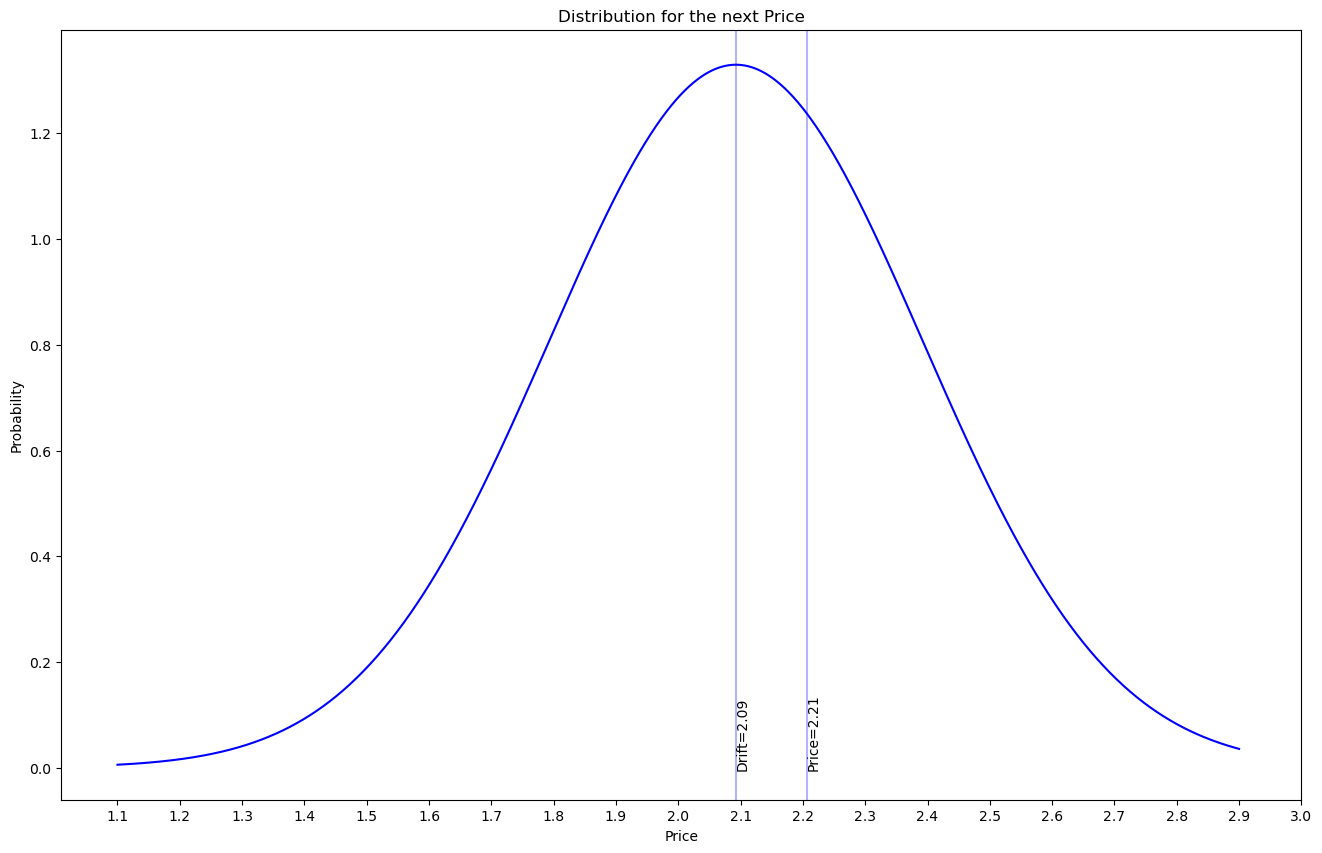

In [6]:
hi_bid = round_to(hi_latent, TICKSIZE)
hi_mid = hi_bid + TICKSIZE / 2
hi_ask = hi_bid + TICKSIZE

hi_drift = pripro.dynamics.theta * (pripro.dynamics.mu - hi_mid) * pripro.dynamics.deltat
hi_mean = hi_mid + hi_drift
std = pripro.dynamics.sigma * pripro.dynamics.deltat**0.5

prices = np.linspace(round_to(hi_mean - std * 3, TICKSIZE), round_to(hi_mean + std * 3, TICKSIZE), 1000)
pdf = stats.norm.pdf(prices, hi_mean, std)

fig, axs = plt.subplots()
axs.plot(prices, pdf, color='b')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

xti = np.round(np.arange(prices.min(), prices.max()+TICKSIZE, TICKSIZE), 2)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

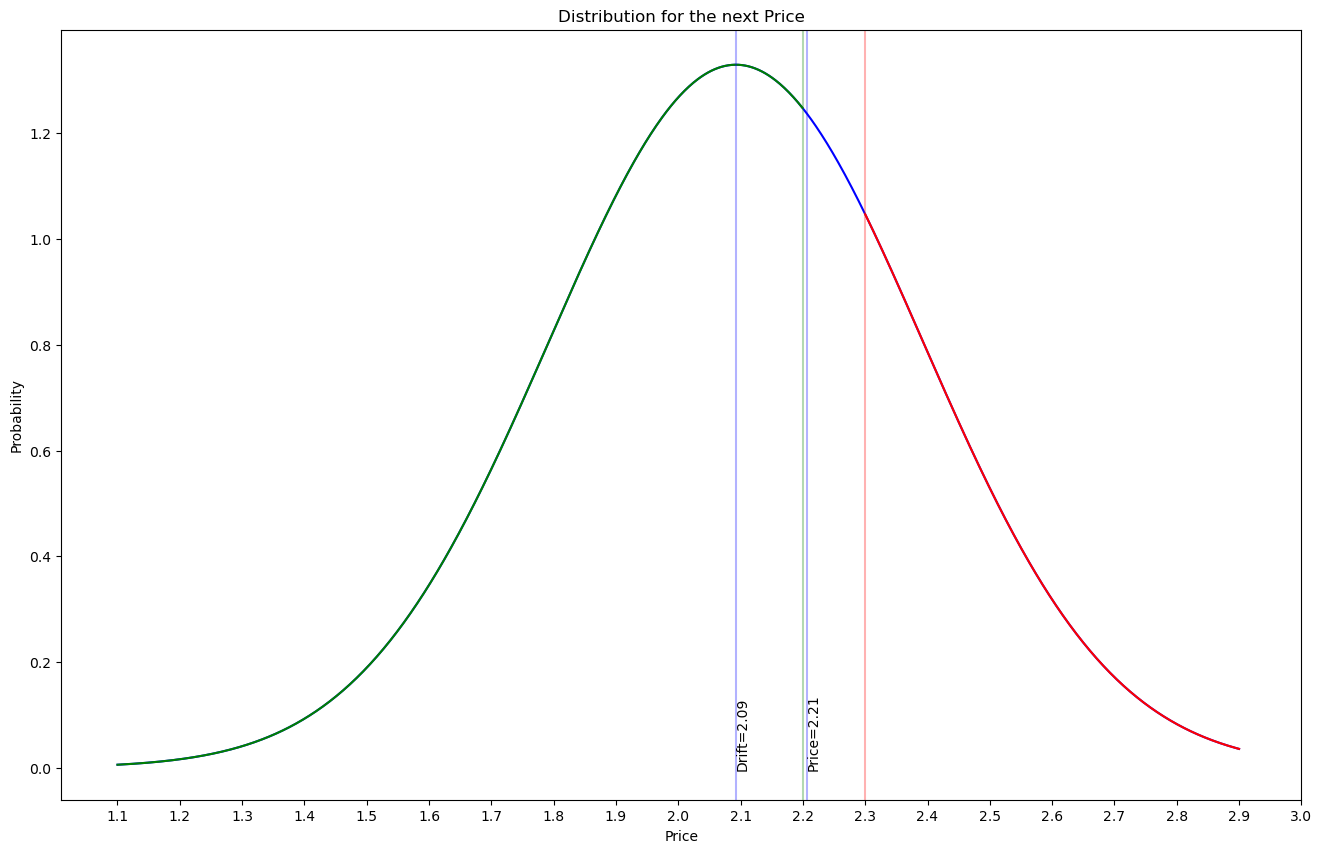

In [7]:
mask_do = prices <= hi_bid
mask_up = hi_ask <= prices

fig, axs = plt.subplots()

axs.plot(prices, pdf, color='b')
axs.plot(prices[mask_do], pdf[mask_do], color='g')
axs.plot(prices[mask_up], pdf[mask_up], color='r')
axs.axvline(hi_mean, color='b', alpha=0.3)
axs.axvline(hi_latent, color='b', alpha=0.3)
axs.axvline(hi_bid, color='g', alpha=0.3)
axs.axvline(hi_ask, color='r', alpha=0.3)

axs.text(hi_latent, 0, f"Price={hi_latent:.2f}", rotation=90)
axs.text(hi_mean, 0, f"Drift={hi_mean:.2f}", rotation=90)

axs.set(title="Distribution for the next Price", xlabel="Price", ylabel="Probability", xticks=xti, xticklabels=xti)

plt.show()

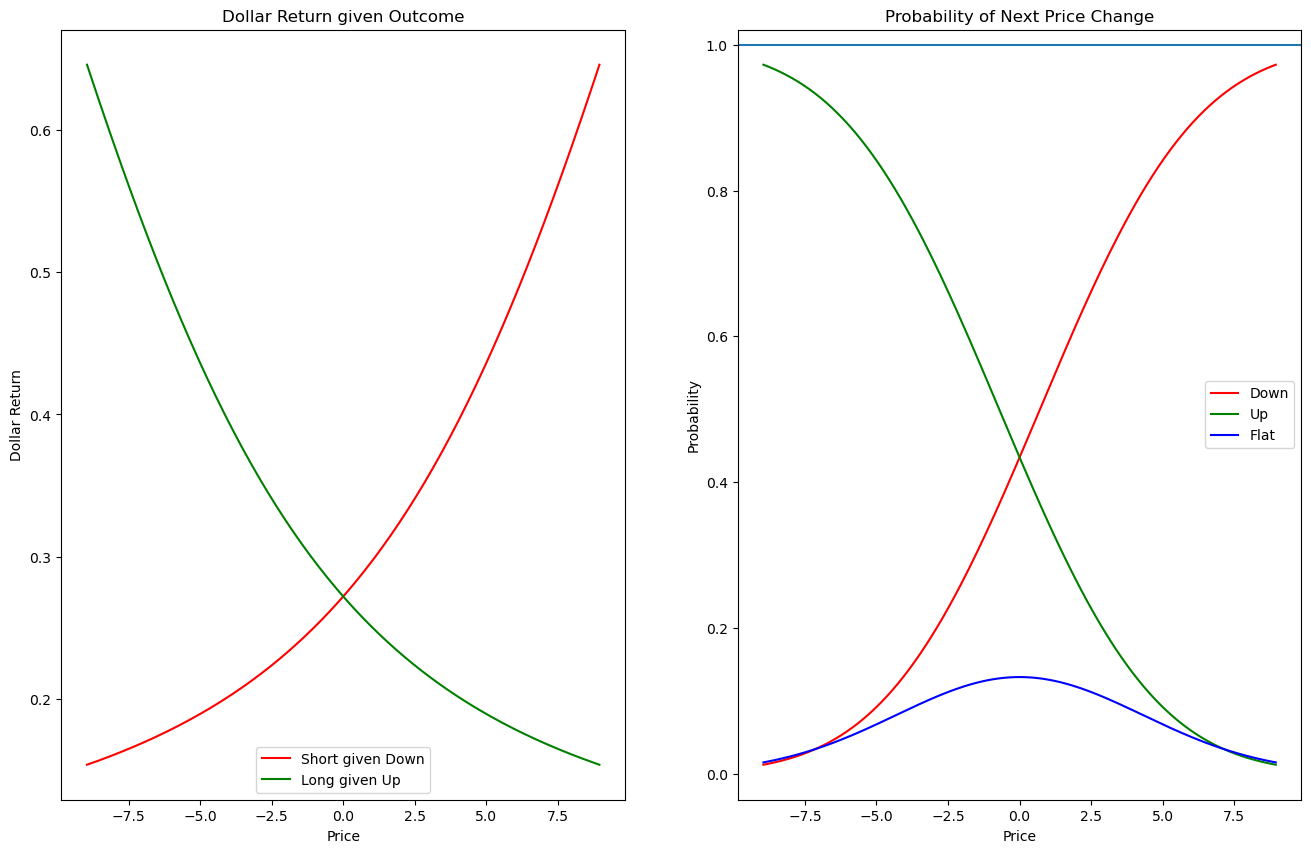

In [8]:
strat = MeanRevertingStrategy(pripro, 100, 3, 1)

fig, axs = plt.subplots(1,2)

strat.plot_sizing_params(axs)

plt.show()

#### Kelly Criterion

$$
\begin{aligned}
    f^* &= \frac{p}{a} - \frac{q}{b}
\end{aligned}
$$

$p$ is the probability of a positive payoff (win).

$q=1-p$ is the probability of a negative payoff (loss).

$a$ is the payoff of a loss as a percentage return.

$b$ is the payoff of a win as a percentage return.

#### Example

We play a game with a fair coin. You must bet $100 to play and I pay you $130 if you get heads; $75 if you get tails.

$p=0.5, q=0.25, a=0.5, b=0.30 \implies f^*=0.33$

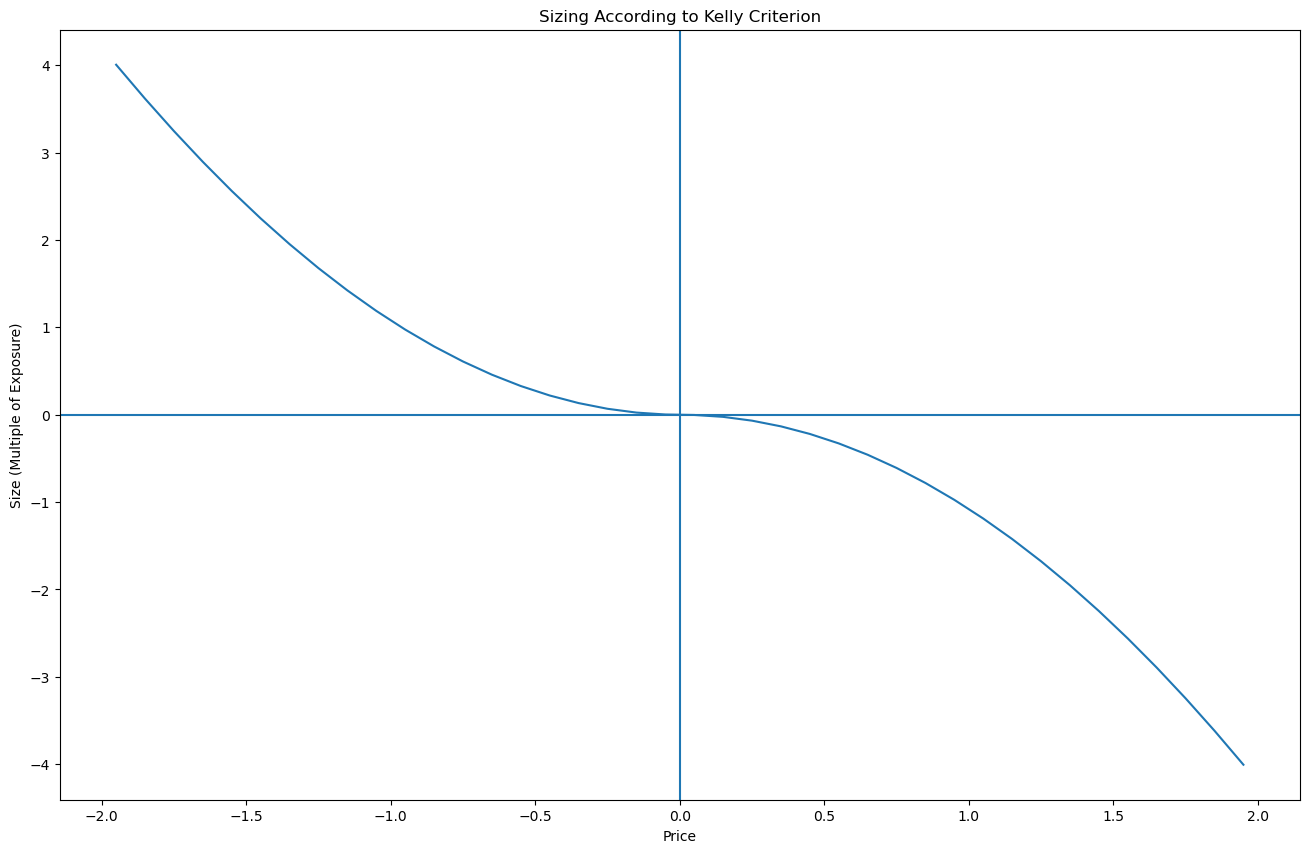

In [9]:
fig, axs = plt.subplots()

strat.plot_sizing_array(axs, np.abs(strat.data["MID"]-strat.pripro.dynamics.mu) < 2)

plt.show()

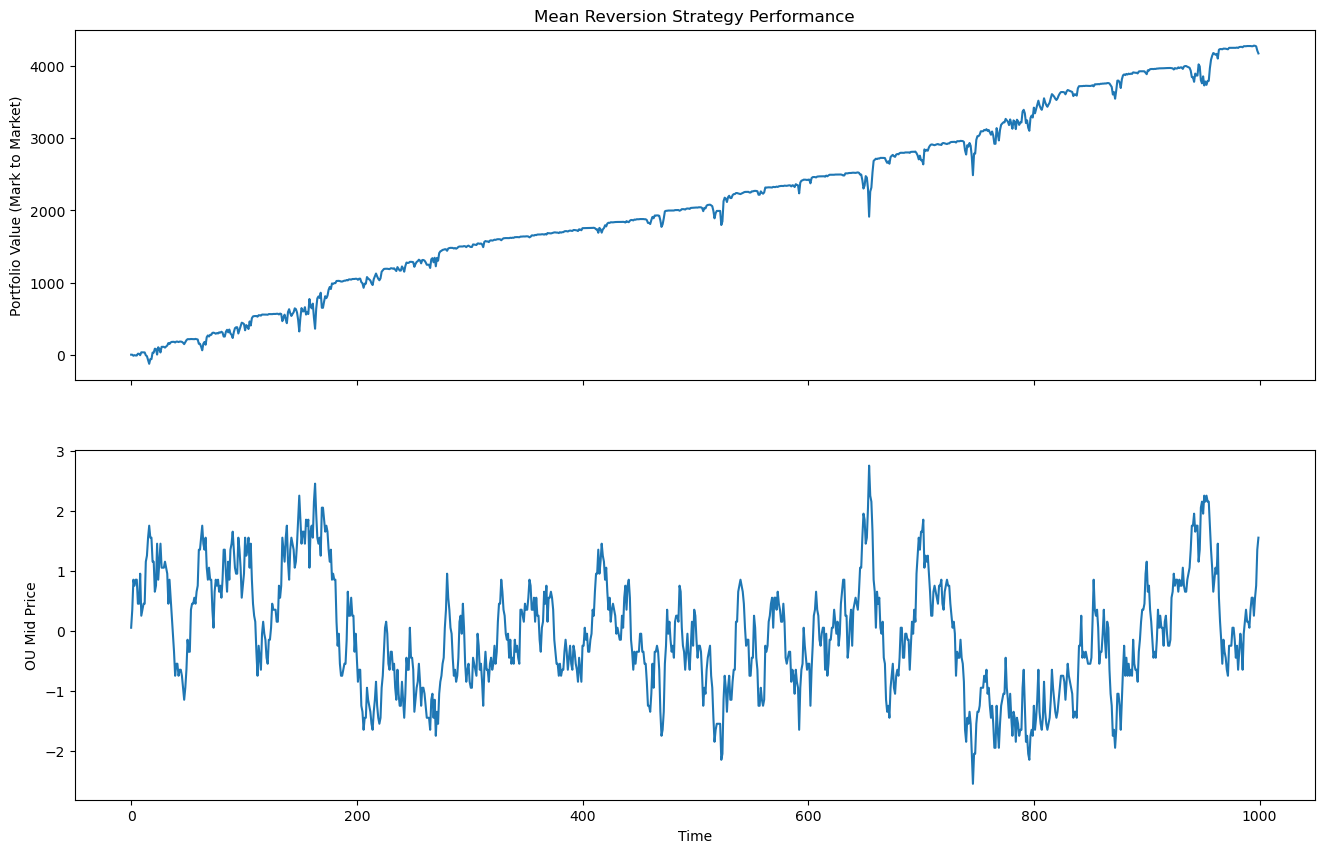

In [10]:
strat.fill_quality = 1.0

strat.backtest()

fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(strat.trades["M2MPORT"])
axs[1].plot(strat.trades["MID"])
axs[0].set(title="Mean Reversion Strategy Performance", ylabel="Portfolio Value (Mark to Market)")
axs[1].set(xlabel="Time", ylabel="OU Mid Price")

plt.show()

In [11]:
display(strat.trades.head(10))
dat = strat.data[(0 < strat.data["MID"]) & (strat.data["MID"] < 1)]
display(dat)

,MID,POS,DCASH,M2MPOS,CASH,M2MPORT
0,0.05,-0.0,-0.0,-0.00,-0.0,-0.00
1,0.35,-13.0,4.3,-4.55,4.3,-0.25
2,0.85,-78.0,47.5,-66.30,51.8,-14.50
3,0.75,-61.0,-11.9,-45.75,39.9,-5.85
4,0.85,-78.0,15.3,-66.30,55.2,-11.10
5,0.85,-78.0,0.0,-66.30,55.2,-11.10
6,0.45,-22.0,-31.8,-9.90,23.4,13.50
7,0.45,-22.0,0.0,-9.90,23.4,13.50
8,0.95,-97.0,62.0,-92.15,85.4,-6.75
9,0.25,-7.0,-50.9,-1.75,34.5,32.75


,BID,MID,ASK,EDO,EUP,PDO,PUP,TOT,KELLY,POS,N@BID,N@ASK
90,-3.197442e-14,0.05,0.1,0.273232,0.270932,0.438411,0.429231,0.867641,-0.002721,-0.0,2.0,-0.0
91,1.000000e-01,0.15,0.2,0.275566,0.268664,0.447624,0.420089,0.867713,-0.024487,-2.0,5.0,-2.0
92,2.000000e-01,0.25,0.3,0.277932,0.266427,0.456866,0.410990,0.867855,-0.067996,-7.0,6.0,-5.0
93,3.000000e-01,0.35,0.4,0.280332,0.264222,0.466131,0.401938,0.868069,-0.133201,-13.0,9.0,-6.0
94,4.000000e-01,0.45,0.5,0.282766,0.262049,0.475414,0.392939,0.868353,-0.220034,-22.0,11.0,-9.0
95,5.000000e-01,0.55,0.6,0.285234,0.259905,0.484711,0.383997,0.868708,-0.328403,-33.0,13.0,-11.0
96,6.000000e-01,0.65,0.7,0.287737,0.257792,0.494016,0.375116,0.869132,-0.458193,-46.0,15.0,-13.0
97,7.000000e-01,0.75,0.8,0.290276,0.255708,0.503324,0.366301,0.869625,-0.609270,-61.0,17.0,-15.0
98,8.000000e-01,0.85,0.9,0.292850,0.253654,0.512631,0.357556,0.870187,-0.781475,-78.0,19.0,-17.0
99,9.000000e-01,0.95,1.0,0.295461,0.251629,0.521931,0.348885,0.870815,-0.974632,-97.0,22.0,-19.0


In [12]:
dat["ASK"].values[1:4] @ dat["N@ASK"].values[1:4]

-4.2999999999995735

In [13]:
dat["ASK"].values[4:9] @ dat["N@ASK"].values[4:9]

-47.49999999999777